In [2]:
import fsspec
import cf_xarray
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

In [3]:
# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem(
    "reference", 
    fo='s3://nextgen-dmac-cloud-ingest/nos/ngofs2/nos.ngofs2.fields.best.nc.zarr', 
    remote_protocol='s3', 
    remote_options={'anon':True}, 
    target_protocol='s3', 
    target_options={'anon':True}
)
m = fs.get_mapper("") 

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={}, drop_variables=['Itime2'])
ds

/Users/matthew.iannucci/Developer/ocean-notebooks/venv/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:             (time: 253, four: 4, nele: 569405, node: 303714,
                         three: 3, maxnode: 10, maxelem: 8, siglev: 41,
                         siglay: 40)
Coordinates:
    lat                 (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    latc                (nele) float32 dask.array<chunksize=(569405,), meta=np.ndarray>
    lon                 (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    lonc                (nele) float32 dask.array<chunksize=(569405,), meta=np.ndarray>
    siglay              (siglay, node) float32 dask.array<chunksize=(40, 303714), meta=np.ndarray>
    siglev              (siglev, node) float32 dask.array<chunksize=(41, 303714), meta=np.ndarray>
  * time                (time) datetime64[ns] 2024-01-28T03:00:00 ... 2024-02...
Dimensions without coordinates: four, nele, node, three, maxnode, maxelem
Data variables: (12/41)
    Itime               (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    Times               (time) |S26 dask.array<chunksize=(1,), meta=np.ndarray>
    a1u                 (four, nele) float32 dask.array<chunksize=(4, 569405), meta=np.ndarray>
    a2u                 (four, nele) float32 dask.array<chunksize=(4, 569405), meta=np.ndarray>
    art1                (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    art2                (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    ...                  ...
    ww                  (time, siglay, nele) float32 dask.array<chunksize=(1, 40, 569405), meta=np.ndarray>
    x                   (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    xc                  (nele) float32 dask.array<chunksize=(569405,), meta=np.ndarray>
    y                   (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    yc                  (nele) float32 dask.array<chunksize=(569405,), meta=np.ndarray>
    zeta                (time, node) float32 dask.array<chunksize=(1, 303714), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                 CF-1.0
    CoordinateProjection:        init=nad83:4205
    CoordinateSystem:            GeoReferenced
    GroundWater_Forcing:         GROUND WATER FORCING IS OFF!
    River_Forcing:               THERE ARE 63 RIVERS IN THIS MODEL.\nRIVER IN...
    Surface_Heat_Forcing:        FVCOM variable surface heat forcing file:\nF...
    ...                          ...
    Tidal_Forcing:               TIDAL ELEVATION FORCING IS OFF!
    history:                     model started at: 28/01/2024   03:15
    institution:                 School for Marine Science and Technology
    references:                  http://fvcom.smast.umassd.edu, http://codfis...
    source:                      FVCOM_4.3
    title:                       NGOFS2

## Requirement

Subset FVCOM dataset given a polygon

## Research

https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python


### Example Polygon

Drawn with: https://geojson.io/#map=7.41/29.807/-88.679

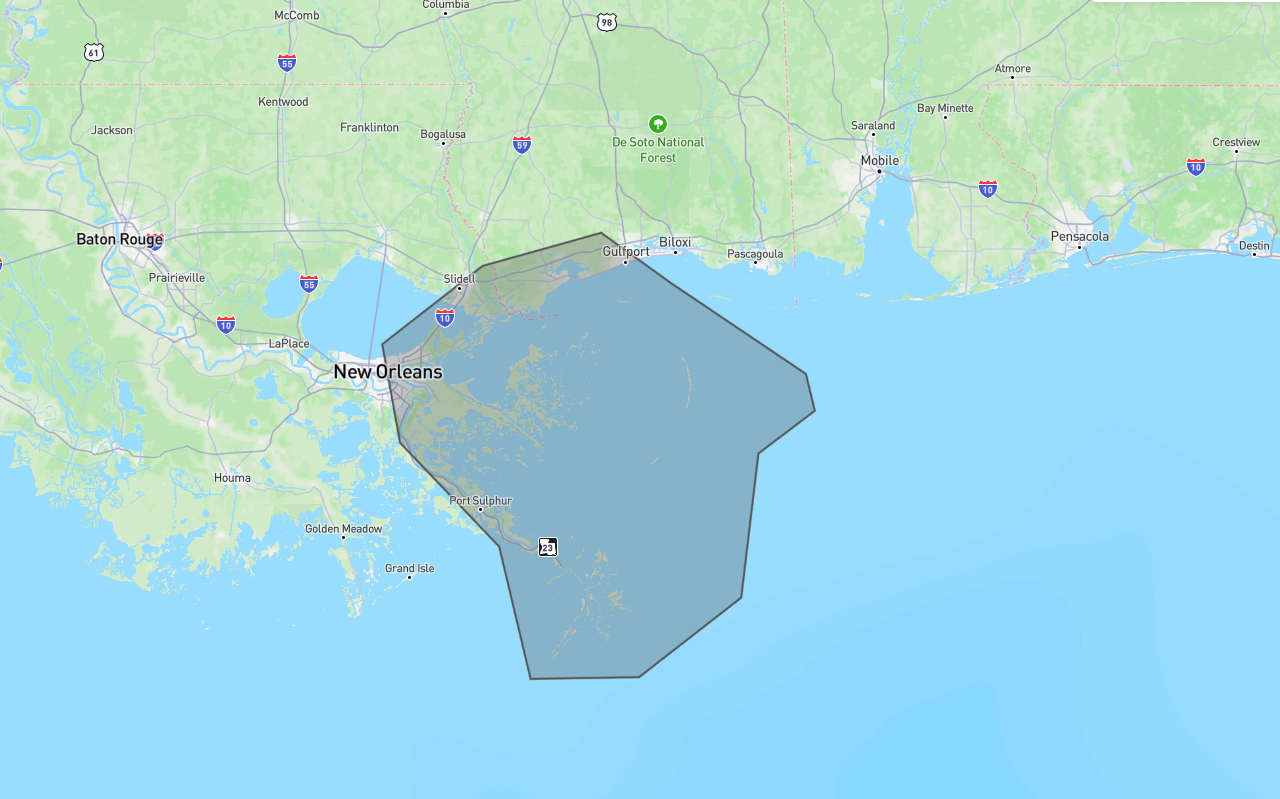

In [4]:
polygon = np.array(
    [
        [-88.90580394001934, 30.29241252023394],
        [-89.19516286474344, 30.472177580997183],
        [-89.68564387438431, 30.353800554455674],
        [-90.10008710994322, 30.07406870382799],
        [-90.02651730481438, 29.72115942943863],
        [-89.61697872293067, 29.347768286358786],
        [-89.48700540053677, 28.869972870160396],
        [-89.03822958925102, 28.876415308359796],
        [-88.6164293731791, 29.163769289372496],
        [-88.54531189488806, 29.682817158850725],
        [-88.31234084531368, 29.836098340764792],
        [-88.3491257478779, 29.967902324410517],
        [-88.90580394001934, 30.29241252023394],
    ]
)
x = ds.lon.values
x = np.where(x > 180, x - 360, x)
y = ds.lat.values

### First Implementation

From: https://stackoverflow.com/a/57999874

In [5]:
def ray_tracing_numpy(x,y,poly):
    n = len(poly)
    inside = np.zeros(len(x),np.bool_)
    p2x = 0.0
    p2y = 0.0
    xints = 0.0
    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        idx = np.nonzero((y > min(p1y,p2y)) & (y <= max(p1y,p2y)) & (x <= max(p1x,p2x)))[0]
        if p1y != p2y:
            xints = (y[idx]-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
        if p1x == p2x:
            inside[idx] = ~inside[idx]
        else:
            idxx = idx[x[idx] <= xints]
            inside[idxx] = ~inside[idxx]    

        p1x,p1y = p2x,p2y
    return inside   

Find the nodes that are inside the polygon

In [6]:
%%time 
node_inside = ray_tracing_numpy(x,y,polygon)

CPU times: user 5.54 ms, sys: 2.79 ms, total: 8.33 ms
Wall time: 9.91 ms


If any nodes in an element are inside the polygon, the element is inside the polygon so make sure all of the relevent nodes and elements are unmasked

In [7]:
tris = ds.nv.T - 1
tri_mask = node_inside[tris]
elements_inside = tri_mask.any(axis=1)
tri_mask[elements_inside] = True
node_inside[tris] =  tri_mask

Reindex the nodes and elements to remove the masked ones

In [8]:
selected_nodes = np.sort(np.unique(tris[elements_inside].values.flatten()))
selected_elements = np.sort(np.unique(np.where(elements_inside)))

In [12]:
nv_new = np.searchsorted(selected_nodes, ds.nv.T[selected_elements]).T
nbe_new = np.searchsorted(selected_elements, ds.nbe.T[selected_elements].values).T
nbsn_new = np.searchsorted(selected_nodes, ds.nbsn.T[selected_nodes].values).T
nbve_new = np.searchsorted(selected_elements, ds.nbve.T[selected_nodes].values).T
ntsn_new = np.searchsorted(selected_nodes, ds.ntsn[selected_nodes].values).T
ntve_new = np.searchsorted(selected_elements, ds.ntve[selected_nodes].values).T

Down select the relevent nodes and elements into a new dataset

In [13]:
ds_subset = ds[['zeta', 'u', 'v', 'nv', 'nbe', 'nbsn', 'nbve', 'ntsn', 'ntve']].cf.isel(time=0).sel(node=selected_nodes, nele=selected_elements)
ds_subset['nv'][:] = nv_new
ds_subset['nbe'][:] = nbe_new
ds_subset['nbsn'][:] = nbsn_new
ds_subset['nbve'][:] = nbve_new
ds_subset['ntsn'][:] = ntsn_new
ds_subset['ntve'][:] = ntve_new
ds_subset

<xarray.Dataset>
Dimensions:  (node: 54024, siglay: 40, nele: 99246, three: 3, maxnode: 10,
              maxelem: 8)
Coordinates:
    lat      (node) float32 dask.array<chunksize=(54024,), meta=np.ndarray>
    latc     (nele) float32 dask.array<chunksize=(99246,), meta=np.ndarray>
    lon      (node) float32 dask.array<chunksize=(54024,), meta=np.ndarray>
    lonc     (nele) float32 dask.array<chunksize=(99246,), meta=np.ndarray>
    siglay   (siglay, node) float32 dask.array<chunksize=(40, 54024), meta=np.ndarray>
    time     datetime64[ns] 2024-01-28T03:00:00
Dimensions without coordinates: node, nele, three, maxnode, maxelem
Data variables:
    zeta     (node) float32 dask.array<chunksize=(54024,), meta=np.ndarray>
    u        (siglay, nele) float32 dask.array<chunksize=(40, 99246), meta=np.ndarray>
    v        (siglay, nele) float32 dask.array<chunksize=(40, 99246), meta=np.ndarray>
    nv       (three, nele) int32 dask.array<chunksize=(3, 99246), meta=np.ndarray>
    nbe      (three, nele) int32 dask.array<chunksize=(3, 99246), meta=np.ndarray>
    nbsn     (maxnode, node) int32 dask.array<chunksize=(10, 54024), meta=np.ndarray>
    nbve     (maxelem, node) int32 dask.array<chunksize=(8, 54024), meta=np.ndarray>
    ntsn     (node) int32 dask.array<chunksize=(54024,), meta=np.ndarray>
    ntve     (node) int32 dask.array<chunksize=(54024,), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                 CF-1.0
    CoordinateProjection:        init=nad83:4205
    CoordinateSystem:            GeoReferenced
    GroundWater_Forcing:         GROUND WATER FORCING IS OFF!
    River_Forcing:               THERE ARE 63 RIVERS IN THIS MODEL.\nRIVER IN...
    Surface_Heat_Forcing:        FVCOM variable surface heat forcing file:\nF...
    ...                          ...
    Tidal_Forcing:               TIDAL ELEVATION FORCING IS OFF!
    history:                     model started at: 28/01/2024   03:15
    institution:                 School for Marine Science and Technology
    references:                  http://fvcom.smast.umassd.edu, http://codfis...
    source:                      FVCOM_4.3
    title:                       NGOFS2

Visualize to confirm

In [14]:
zeta = ds_subset.zeta
tris = tri.Triangulation(zeta.cf['longitude'], zeta.cf['latitude'], ds_subset.nv.T - 1)
plt.tripcolor(tris, zeta, shading='flat')

ValueError: triangles are indices into the points and must be in the range 0 <= i < 54024 but found value 299691

In [120]:
%%time 

ds_subset.to_netcdf('ngofs2_subset.nc')

CPU times: user 156 ms, sys: 85.1 ms, total: 241 ms
Wall time: 4.16 s
